Finding a Machine Learning Model
=================

There are many different types of models we can use for classification,
each of these models have types of problems they are well suited to.
The goal of this notebook is to identify algorithms 
that will effectively classify our dataset
which we can then investigate further.

### Collating the models

The first step here is creating a list of models we would like to test.
An excellent property of scikit-learn is 
that all the algorithms have the same API,
allowing us to treat them all in the same way. 

This is not an exhastive list of all the possible classifiers in scikit-learn,
just a smattering for comparison.
For a more exhastive list check out [the scikit-learn documentation](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning),
and feel free to add more to the list.

In [1]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

ml_models = {
    'LR': LogisticRegression(),
    'SGD': SGDClassifier(tol=1e-3, max_iter=1000),
    'LDA': LinearDiscriminantAnalysis(),
    'DT': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'NB': GaussianNB(),
    'SVM': SVC(),
    'NN': MLPClassifier()
}

### Loading the training data

We need to load in the training dataset we created in the first notebook.
At this point we are interested in two sets of data,

- $X$, the input data which is the orientation of the six nearest neighbours
- $Y$, the true labelled classification of the data.

In [2]:
import pandas

training_dataset = pandas.read_hdf('data/training_data.h5', key='trimer')
X = training_dataset[['orient0', 'orient1', 'orient2', 'orient3', 'orient4', 'orient5']].values
Y = training_dataset['class'].values
classes = training_dataset['class'].unique()

### Testing the Models

With a collection of models to test,
we now need some method of testing the models to compare them.
To perform the initial screening of datasets
we are going to break our training data into two groups,

- the training set, comprising 80% of the molecules
- the validation set, comprising the remaining 20%.

This division of the dataset gives us a set of data 
previously unseen by the algorithms,
giving us a method of testing whether
the algorithm is acutally learning the underlying features,
or just 'memorising' the training data.
This division of data will be through a random selection
so as not to bias the selection of data.

In [3]:
from sklearn import model_selection

validation_size = 0.20
seed = 7

selected = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)
X_train, X_validation, Y_train, Y_validation = selected

To get an idea of the models which
warrant a further investigation,
we can iterate through each of our models.
Each model is scored by breaking the training data into `n_splits`,
using one of these splits for testing and
the remaining splits for training.
This process is referred to as *cross validation*
and typically the number of splits is 10.
For the purposes of this running in a reasonable amount of time,
`n_splits` is set to 2.

In [4]:
scoring='accuracy'
n_splits = 2
# Typically n_splits would be 10 but it runs much slower
#n_splits = 10

# Iterate through each model in our dictionary of models
for name, model in ml_models.items():
    kfold = model_selection.KFold(n_splits=n_splits, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    print(f'{name:5s}: {cv_results.mean():.5f} ± {cv_results.std():.5f}')

LR   : 0.91845 ± 0.00067
SGD  : 0.91503 ± 0.00062
LDA  : 0.90854 ± 0.00134
DT   : 0.93097 ± 0.00081
KNN  : 0.95798 ± 0.00025
NB   : 0.93312 ± 0.00084
SVM  : 0.95165 ± 0.00066
NN   : 0.95561 ± 0.00122


Out of all the algorithms tested, 
there are three that stand out 

- K-Nearest Neighbours (KNN),
- Support Vector Machine (SVM), and
- Neural Network (NN)

with accuracies in excess of 95%. 

So with these three algorithms it is likely worth
tweaking the algorithms slightly from 
the defualt paramters in an effort to improve performance.
It is also worth understanding which classes
each of these algorithms is strongest at classifying.
For this additional data we are going to be using a [confusion matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).
In a confusion matrix, 
the diagonal elements represent the correct classifications,
while the off diagonal elements are the values 
which were incorrectly classified.

Below we have a handy function from the scikit-learn documentation
that will nicely plot the confusion matrix as a heatmap. 

In [5]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

It is this point where our breaking the data into
training and validation sets becomes useful.
We can train a classifier using the training set,
then generate predictions of the validation dataset
using the known values of the validation data
to generate the confusion matrix.

Normalized confusion matrix


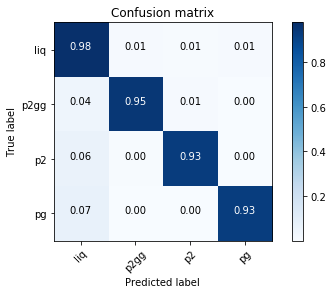

In [6]:
knn = ml_models['KNN']
knn.fit(X_train, Y_train)
predictions = knn.predict(X_validation)
plot_confusion_matrix(confusion_matrix(Y_validation, predictions, labels=classes), classes, normalize=True)

Normalized confusion matrix


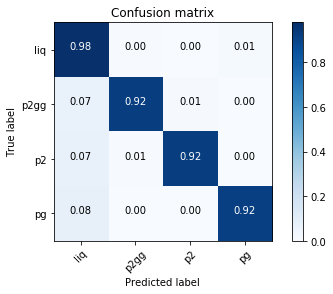

In [7]:
svm = ml_models['SVM']
svm.fit(X_train, Y_train)
predictions = svm.predict(X_validation)
plot_confusion_matrix(confusion_matrix(Y_validation, predictions, labels=classes), classes, normalize=True)

Normalized confusion matrix


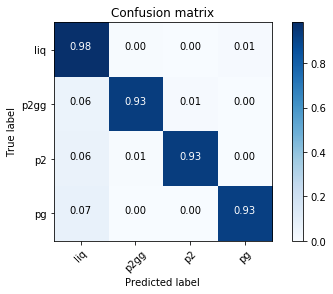

In [8]:
nn = ml_models['NN']
nn.fit(X_train, Y_train)
predictions = nn.predict(X_validation)
plot_confusion_matrix(confusion_matrix(Y_validation, predictions, labels=classes), classes, normalize=True)

It is interesting to note that all of the models
have the most difficulty with the liquid/crystal characterisation,
with the largest proportion of false positives being 
crystal incorrectly classified as liquid. 
To make this model we have created persistent
it needs to be saved which is done using `joblib`.

In [9]:
from sklearn.externals import joblib
joblib.dump(ml_models['KNN'], 'data/knn-model.pkl') 

['data/knn-model.pkl']

Now we have a model, we can look at using it in [production](03_ML_in_Production.ipynb) to measure useful quantities.